In [426]:
#import dependencies

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

### Merging stocks Data -for each vaccine into combined vaccine stock

In [427]:


# Dictionary containing tickers and corresponding file paths
csv_files = {
    'PFE': 'Resources/pfizer_data.csv',  
    'AZN': 'Resources/Astrazeneca_data.csv',
    'BNTX': 'Resources/Bio n Tech_data.csv',
    'MRNA': 'Resources/Moderna_data.csv',
    'JNJ': 'Resources/JOhnson n Johnson_data.csv',
    'GSK': 'Resources/GSK Vaccine_data.csv',
    'NVAX':'Resources/Novavax, Inc_data.csv',
    'SNY': 'Resources/Sanofi_data.csv'
}

# Empty list to hold data from each file

combined_data = []

# Loop through each ticker and corresponding file
for ticker, file in csv_files.items():
    # Use Path() to handle both relative and absolute paths
    file_path = Path(file)

    # Check if the file exists before trying to load it
    if file_path.exists():
        # Load the current CSV file
        data = pd.read_csv(file_path)

       
        # Ensure the 'Ticker' column exists or add it
        data['Ticker'] = ticker
        data = data[['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

        # Append this data to the combined list
        combined_data.append(data)

        print(f"Loaded data for {ticker} successfully.")
    else:
        print(f"Error: File for {ticker} at path '{file_path}' not found.")

# Concatenate all the data into a single DataFrame, if any files were successfully loaded
if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)

    # Save the combined data to a new CSV file
    combined_df.to_csv('Output/combined_vaccine_stocks.csv', index=False)

    # Preview the first few rows of the combined data
    print(combined_df.head())
    
else:
    print("No data to combine.")




Loaded data for PFE successfully.
Loaded data for AZN successfully.
Loaded data for BNTX successfully.
Loaded data for MRNA successfully.
Loaded data for JNJ successfully.
Loaded data for GSK successfully.
Loaded data for NVAX successfully.
Loaded data for SNY successfully.
  Ticker        Date       Open       High        Low      Close  Adj Close  \
0    PFE  2019-01-02  40.910816  41.271347  40.455406  41.034157  32.436306   
1    PFE  2019-01-03  41.024670  41.119545  39.800758  39.886147  31.528837   
2    PFE  2019-01-04  40.265656  41.129032  40.094875  40.796963  32.248802   
3    PFE  2019-01-07  40.863377  41.385201  40.664139  41.015179  32.421299   
4    PFE  2019-01-08  41.328274  41.461102  40.939278  41.204933  32.571297   

     Volume  
0  26430315  
1  28503533  
2  27145348  
3  20995469  
4  19677231  


### Cleaning the Data-

In [428]:
# Check for Missing values-

missing_values = combined_df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Handle missing values (example: drop rows with missing values)
combined_df.dropna(inplace=True)

Missing values per column:
 Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [429]:
# Check for Duplicates-

duplicates = combined_df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Remove duplicate rows if any
stock_data_cleaned = combined_df.drop_duplicates()

Number of duplicate rows: 0


In [430]:
#Ensure 'Date' column is in datetime format

stock_data_cleaned['Date'] = pd.to_datetime(stock_data_cleaned['Date'])

# Verify the data types
print(stock_data_cleaned.dtypes)

Ticker               object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [431]:
# Identify outliers using IQR

# Convert relevant columns to numeric, if not already
columns_to_convert = ['Open', 'Close', 'Volume']  # Add all relevant columns

for col in columns_to_convert:
    stock_data_cleaned[col] = pd.to_numeric(stock_data_cleaned[col], errors='coerce')

# Drop rows with NaN values in the columns of interest
stock_data_cleaned = stock_data_cleaned.dropna(subset=columns_to_convert)

# Calculate the quartiles and IQR for the numeric columns
Q1 = stock_data_cleaned[columns_to_convert].quantile(0.25)
Q3 = stock_data_cleaned[columns_to_convert].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers using the IQR method
outliers = stock_data_cleaned[((stock_data_cleaned[columns_to_convert] < (Q1 - 1.5 * IQR)) | (stock_data_cleaned[columns_to_convert] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Outliers:\n", outliers)

# Optionally, remove outliers
stock_data_cleaned_no_outliers = stock_data_cleaned[~((stock_data_cleaned[columns_to_convert] < (Q1 - 1.5 * IQR)) | (stock_data_cleaned[columns_to_convert] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Optional: print or work with the cleaned data
print("Data without outliers:\n", stock_data_cleaned_no_outliers)



Outliers:
      Ticker       Date       Open       High        Low      Close  Adj Close  \
0       PFE 2019-01-02  40.910816  41.271347  40.455406  41.034157  32.436306   
1       PFE 2019-01-03  41.024670  41.119545  39.800758  39.886147  31.528837   
2       PFE 2019-01-04  40.265656  41.129032  40.094875  40.796963  32.248802   
3       PFE 2019-01-07  40.863377  41.385201  40.664139  41.015179  32.421299   
4       PFE 2019-01-08  41.328274  41.461102  40.939278  41.204933  32.571297   
...     ...        ...        ...        ...        ...        ...        ...   
8531   NVAX 2023-09-07   9.820000   9.980000   8.700000   9.150000   9.150000   
8533   NVAX 2023-09-11   9.020000   9.020000   7.730000   7.820000   7.820000   
8549   NVAX 2023-10-03   7.080000   8.150000   6.730000   7.670000   7.670000   
8601   NVAX 2023-12-15   5.730000   5.830000   5.380000   5.400000   5.400000   
9520    SNY 2022-08-11  42.020000  44.270000  41.980000  43.419998  40.145008   

        Volume  

In [432]:
# Summary of cleaned data
print(stock_data_cleaned.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9869 entries, 0 to 9868
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     9869 non-null   object        
 1   Date       9869 non-null   datetime64[ns]
 2   Open       9869 non-null   float64       
 3   High       9869 non-null   float64       
 4   Low        9869 non-null   float64       
 5   Close      9869 non-null   float64       
 6   Adj Close  9869 non-null   float64       
 7   Volume     9869 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 616.9+ KB
None


In [433]:
# Filter all rows (:) and specific columns: 'Ticker', 'Date', 'Open', 'Close'
filtered_df = combined_df.loc[:, ['Ticker', 'Date', 'Open', 'Close','Volume']]

# Convert 'Date' column to datetime format
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'], errors='coerce')

filtered_df

,Ticker,Date,Open,Close,Volume
0,PFE,2019-01-02,40.910816,41.034157,26430315
1,PFE,2019-01-03,41.024670,39.886147,28503533
2,PFE,2019-01-04,40.265656,40.796963,27145348
3,PFE,2019-01-07,40.863377,41.015179,20995469
4,PFE,2019-01-08,41.328274,41.204933,19677231
...,...,...,...,...,...
9864,SNY,2023-12-22,49.169998,48.740002,979100
9865,SNY,2023-12-26,48.709999,49.080002,874500
9866,SNY,2023-12-27,49.349998,49.750000,979700
9867,SNY,2023-12-28,49.549999,49.380001,1081800


### Calulate Yearly change in stocks

In [434]:
# Group by Ticker and Year, and aggregate first 'Open', last 'Close', and total 'Volume'

yearly_grouped = filtered_df.groupby([filtered_df['Ticker'], filtered_df['Date'].dt.year]).agg(
    
    first_open=('Open', 'first'),   # First open price in the year
    last_close=('Close', 'last'),   # Last close price in the year
    total_volume=('Volume', 'sum')  # Sum of volume for each year

).reset_index()


In [435]:
# Step 4: Calculate the yearly change (absolute difference or percentage)
yearly_grouped['change'] = yearly_grouped['last_close'] - yearly_grouped['first_open']

In [436]:
# Calculate the percentage change
yearly_grouped['percentage_change'] = (yearly_grouped['last_close'] - yearly_grouped['first_open']) / yearly_grouped['first_open'] * 100

#  Print the result, including 'Ticker' and 'Year'
print(yearly_grouped[['Ticker', 'Date', 'first_open', 'last_close', 'change', 'percentage_change']])

   Ticker  Date  first_open  last_close      change  percentage_change
0     AZN  2019   37.720001   49.860001   12.139999          32.184515
1     AZN  2020   50.299999   49.990002   -0.309998          -0.616297
2     AZN  2021   50.919998   58.250000    7.330002          14.395134
3     AZN  2022   58.270000   67.800003    9.530003          16.354904
4     AZN  2023   68.650002   67.349998   -1.300003          -1.893668
5    BNTX  2019   16.500000   33.880001   17.380001         105.333340
6    BNTX  2020   35.750000   81.519997   45.769997         128.027963
7    BNTX  2021   85.450996  257.799988  172.348991         201.693367
8    BNTX  2022  253.869995  150.220001 -103.649994         -40.827981
9    BNTX  2023  152.940002  105.540001  -47.400002         -30.992547
10    GSK  2019   37.770000   46.990002    9.220001          24.410911
11    GSK  2020   46.810001   36.799999  -10.010002         -21.384324
12    GSK  2021   37.720001   44.099998    6.379997          16.914096
13    

In [437]:
# Define the function to calculate base 100
def calculate_base_100(group):
    # Add 1 to percentage_change to calculate cumulative change (1 + percentage_change/100)
    group['adjusted_change'] = (group['percentage_change'] / 100) + 1
    
    # Calculate base 100 as cumulative product, starting with 100
    group['base_100'] = group['adjusted_change'].cumprod() * 100

     # Set the first base_100 value explicitly to 100 for proper normalization
    group['base_100'].iat[0] = 100
    
    return group

# Apply the function to each ticker group
yearly_change_df = yearly_grouped.groupby('Ticker').apply(calculate_base_100)

# Drop the temporary 'adjusted_change' column (optional)
yearly_change_df.drop(columns=['adjusted_change'], inplace=True)


# Now 'yearly_change_df' contains the 'base_100' column
print(yearly_change_df)

          Ticker  Date  first_open  last_close  total_volume      change  \
Ticker                                                                     
AZN    0     AZN  2019   37.720001   49.860001     996526900   12.139999   
       1     AZN  2020   50.299999   49.990002    1519552100   -0.309998   
       2     AZN  2021   50.919998   58.250000    2140467100    7.330002   
       3     AZN  2022   58.270000   67.800003    1649977200    9.530003   
       4     AZN  2023   68.650002   67.349998    1260493800   -1.300003   
BNTX   5    BNTX  2019   16.500000   33.880001      15269100   17.380001   
       6    BNTX  2020   35.750000   81.519997     609044300   45.769997   
       7    BNTX  2021   85.450996  257.799988     795461900  172.348991   
       8    BNTX  2022  253.869995  150.220001     334527400 -103.649994   
       9    BNTX  2023  152.940002  105.540001     173063800  -47.400002   
GSK    10    GSK  2019   37.770000   46.990002     644640200    9.220001   
       11   

C:\Users\Muskan\AppData\Local\Temp\ipykernel_28456\1107281016.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_change_df = yearly_grouped.groupby('Ticker').apply(calculate_base_100)


In [438]:

yearly_change_df.rename(columns={'Date': 'Year'}, inplace=True)
yearly_change_df

Ticker  Year  first_open  last_close  total_volume      change  \
Ticker                                                                     
AZN    0     AZN  2019   37.720001   49.860001     996526900   12.139999   
       1     AZN  2020   50.299999   49.990002    1519552100   -0.309998   
       2     AZN  2021   50.919998   58.250000    2140467100    7.330002   
       3     AZN  2022   58.270000   67.800003    1649977200    9.530003   
       4     AZN  2023   68.650002   67.349998    1260493800   -1.300003   
BNTX   5    BNTX  2019   16.500000   33.880001      15269100   17.380001   
       6    BNTX  2020   35.750000   81.519997     609044300   45.769997   
       7    BNTX  2021   85.450996  257.799988     795461900  172.348991   
       8    BNTX  2022  253.869995  150.220001     334527400 -103.649994   
       9    BNTX  2023  152.940002  105.540001     173063800  -47.400002   
GSK    10    GSK  2019   37.770000   46.990002     644640200    9.220001   
       11    GSK  2020   46.810001   36.799999    1024869000  -10.010002   
       12    GSK  2021   37.720001   44.099998    1169661000    6.379997   
       13    GSK  2022   44.110001   35.139999    1474139900   -8.970001   
       14    GSK  2023   34.939999   37.060001     835469100    2.120003   
JNJ    15    JNJ  2019  128.130005  145.869995    1786792000   17.739990   
       16    JNJ  2020  145.869995  157.380005    2034813400   11.510010   
       17    JNJ  2021  157.240005  171.070007    1798567900   13.830002   
       18    JNJ  2022  170.210007  176.649994    1823528200    6.439987   
       19    JNJ  2023  176.160004  156.740005    2799625100  -19.419998   
MRNA   20   MRNA  2019   14.930000   19.559999     394813100    4.629999   
       21   MRNA  2020   19.570000  104.470001    4660899500   84.900002   
       22   MRNA  2021  107.230003  253.979996    3347247500  146.749992   
       23   MRNA  2022  247.119995  179.619995    1556196900  -67.500000   
       24   MRNA  2023  180.850006   99.449997     972650100  -81.400009   
NVAX   25   NVAX  2019   34.400002    3.980000     213628860  -30.420002   
       26   NVAX  2020    3.990000  111.510002    1837868900  107.520002   
       27   NVAX  2021  112.699997  143.070007    1213454000   30.370010   
       28   NVAX  2022  144.029999   10.280000    1491520000 -133.749999   
       29   NVAX  2023   10.590000    4.800000    1836904900   -5.790000   
PFE    30    PFE  2019   40.910816   37.172676    6053914076   -3.738140   
       31    PFE  2020   37.286530   36.810001    8569906766   -0.476528   
       32    PFE  2021   36.869999   59.049999    8314020400   22.180000   
       33    PFE  2022   58.500000   51.240002    6084686900   -7.259998   
       34    PFE  2023   51.009998   28.790001    7059174400  -22.219997   
SNY    35    SNY  2019   42.830002   50.200001     357128200    7.369999   
       36    SNY  2020   50.580002   48.590000     425363700   -1.990002   
       37    SNY  2021   48.759998   50.099998     472997200    1.340000   
       38    SNY  2022   50.680000   48.430000     637154100   -2.250000   
       39    SNY  2023   48.400002   49.730000     428741100    1.329998   

           percentage_change     base_100  
Ticker                                     
AZN    0           32.184515   100.000000  
       1           -0.616297   131.369865  
       2           14.395134   150.280733  
       3           16.354904   174.859002  
       4           -1.893668   171.547754  
BNTX   5          105.333340   100.000000  
       6          128.027963   468.217431  
       7          201.693367  1412.580932  
       8          -40.827981   835.852654  
       9          -30.992547   576.800631  
GSK    10          24.410911   100.000000  
       11         -21.384324    97.806479  
       12          16.914096   114.349561  
       13         -20.335527    91.095975  
       14           6.067552    96.623271  
JNJ    15          13.845305   100.000000  
       16           7.890

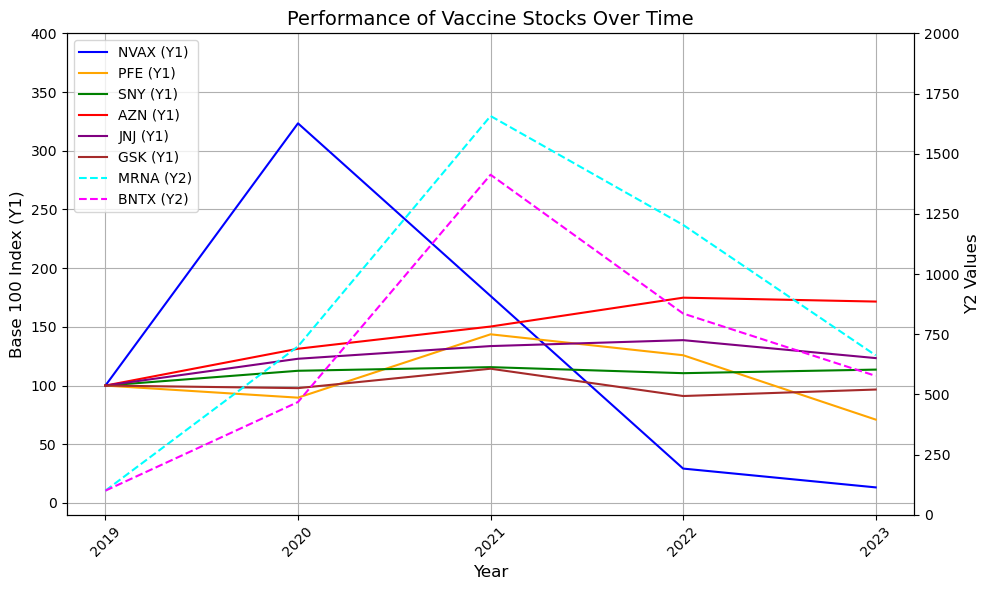

<Figure size 640x480 with 0 Axes>

In [439]:


# Assuming yearly_change_df is already defined and contains the necessary data
# Ensure the 'year' column contains the years in the correct format

# Create the figure and first axis (Y1)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Tickers available in the dataset
tickers = yearly_change_df['Ticker'].unique()

# Define colors for Y1
y1_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Plot on the first y-axis (Y1 - left side)
for i, ticker in enumerate(['NVAX', 'PFE', 'SNY', 'AZN', 'JNJ', 'GSK']):
    ticker_data = yearly_change_df[yearly_change_df['Ticker'] == ticker]
    
    # Plot data points that fit within the range (-10 to 400) on Y1
    y1_data = ticker_data[(ticker_data['base_100'] >= -10) & (ticker_data['base_100'] <= 400)]
    ax1.plot(y1_data['Year'], y1_data['base_100'], label=f'{ticker} (Y1)', color=y1_colors[i])

# Customize the first y-axis (Y1)
ax1.set_title('Performance of Vaccine Stocks Over Time', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Base 100 Index (Y1)', fontsize=12)
ax1.set_ylim(-10, 400)  # Limit for the left y-axis

# Set x-ticks to the unique years in the 'year' column
unique_years = yearly_change_df['Year'].unique()
ax1.set_xticks(unique_years)
ax1.set_xticklabels(unique_years, rotation=45)  # Use the years directly

ax1.grid(True)

# Create a second y-axis (Y2 - right side) that shares the same x-axis
ax2 = ax1.twinx()

# Define colors for Y2
y2_colors = ['cyan', 'magenta']

# Plot on the second y-axis (Y2 - right side)
for i, ticker in enumerate(['MRNA', 'BNTX']):  # Only include MRNA and BNTX
    ticker_data = yearly_change_df[yearly_change_df['Ticker'] == ticker]
    
    # Plot data points that fit within the range (500 to 2000) on Y2
    y2_data = ticker_data[(ticker_data['base_100'] >= 0) & (ticker_data['base_100'] <= 2000)]
    ax2.plot(y2_data['Year'], y2_data['base_100'], linestyle='--', label=f'{ticker} (Y2)', color=y2_colors[i])

# Customize the second y-axis (Y2)
ax2.set_ylabel('Base 100 Index (Y2)', fontsize=12)
ax2.set_ylim(0, 2000)  # Limit for the right y-axis

# Combine both legends and make sure they show correctly
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig('Output/Q1_Performance of Vaccine stocks over time.png')

### Total Stock Volume 

In [440]:
# Total stock Volume for each stock

combined_df

volume_df=combined_df.groupby('Ticker')['Volume'].sum().reset_index()

volume_df

,Ticker,Volume
0,AZN,7567017100
1,BNTX,1927366500
2,GSK,5148779200
3,JNJ,10243326600
4,MRNA,10931807100
5,NVAX,6593376660
6,PFE,36081702542
7,SNY,2321384300


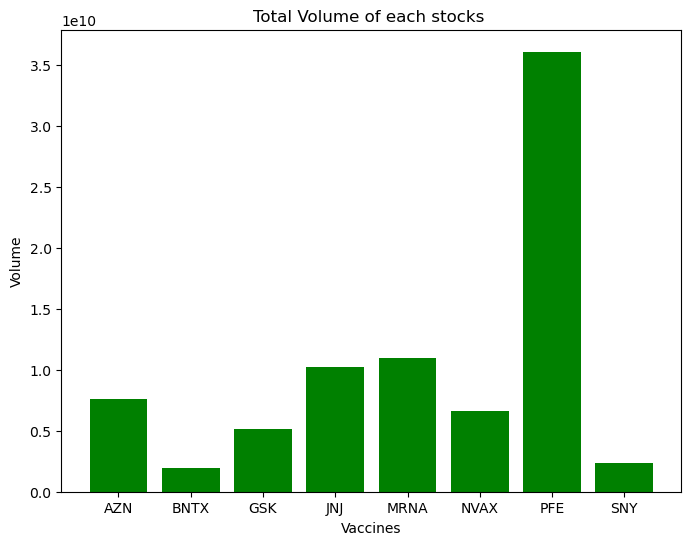

<Figure size 640x480 with 0 Axes>

In [441]:
# bar plot for volume of stock per vaccine 

plt.figure(figsize=(8, 6))
plt.bar(volume_df['Ticker'], volume_df['Volume'], color='green')
plt.title('Total Volume of each stocks ')
plt.xlabel('Vaccines')
plt.ylabel('Volume')
plt.show()
plt.savefig("Output/Q1_Total_Volume_of_Stocks_per_vaccine.png")



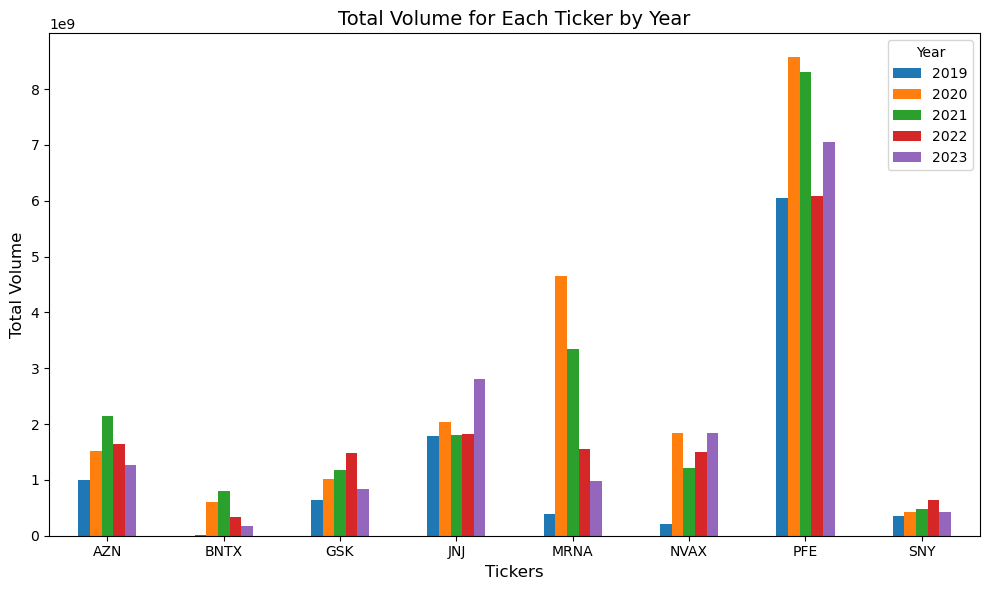

<Figure size 640x480 with 0 Axes>

In [442]:
# Step 1: Pivot the DataFrame to have 'Date' as columns and 'Ticker' as rows
pivoted_data = yearly_grouped.pivot(index='Ticker', columns='Date', values='total_volume')

# Step 2: Plot multibar chart
ax = pivoted_data.plot(kind='bar', figsize=(10, 6))

# Step 3: Customize the plot
plt.title('Total Volume for Each Ticker by Year', fontsize=14)
plt.ylabel('Total Volume', fontsize=12)
plt.xlabel('Tickers', fontsize=12)
plt.xticks(rotation=0)  # Keep ticker labels horizontal
plt.legend(title='Year')
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot
plt.savefig("Output/Q1_Total_Volume_Change For Each Ticker by year.png")

### Calculate Quarterly change of stocks 

In [443]:
# Step 2: Group by quarters

quarterly_change_df = filtered_df.groupby([filtered_df['Ticker'],filtered_df['Date'].dt.to_period('Q')])


quarterly_change_df = filtered_df.groupby([filtered_df['Ticker'], filtered_df['Date'].dt.to_period('Q')]).agg(
    first_open=('Open', 'first'),   # First open price in the quarter
    last_close=('Close', 'last'),   # Last close price in the quarter
    total_volume=('Volume', 'sum')  # Sum of volume for quarter
).reset_index()




In [444]:
# Step 4: Calculate the quarterly change (absolute difference or percentage)
quarterly_change_df['change'] = quarterly_change_df['last_close'] - quarterly_change_df['first_open']

# Calculate the percentage change

quarterly_change_df['percentage_change'] = (quarterly_change_df['last_close'] - quarterly_change_df['first_open']) / quarterly_change_df['first_open'] * 100

quarterly_change_df

,Ticker,Date,first_open,last_close,total_volume,change,percentage_change
0,AZN,2019Q1,37.720001,40.430000,335446900,2.709999,7.184515
1,AZN,2019Q2,41.439999,41.279999,260365900,-0.160000,-0.386100
2,AZN,2019Q3,41.650002,44.570000,213635400,2.919998,7.010800
3,AZN,2019Q4,44.029999,49.860001,187078700,5.830002,13.240977
4,AZN,2020Q1,50.299999,44.660000,262929800,-5.639999,-11.212723
...,...,...,...,...,...,...,...
152,SNY,2022Q4,38.700001,48.430000,171222800,9.730000,25.142117
153,SNY,2023Q1,48.400002,54.419998,124944100,6.019997,12.438009
154,SNY,2023Q2,54.430000,53.900002,94908500,-0.529999,-0.973725
155,SNY,2023Q3,54.169998,53.639999,80304500,-0.529999,-0.978399


In [445]:

# Apply the function to each ticker group
Q_change_df = quarterly_change_df.groupby('Ticker').apply(calculate_base_100)

# Drop the temporary 'adjusted_change' column (optional)
Q_change_df.drop(columns=['adjusted_change'], inplace=True)


# Now 'yearly_change_df' contains the 'base_100' column
print(Q_change_df)

           Ticker    Date  first_open  last_close  total_volume    change  \
Ticker                                                                      
AZN    0      AZN  2019Q1   37.720001   40.430000     335446900  2.709999   
       1      AZN  2019Q2   41.439999   41.279999     260365900 -0.160000   
       2      AZN  2019Q3   41.650002   44.570000     213635400  2.919998   
       3      AZN  2019Q4   44.029999   49.860001     187078700  5.830002   
       4      AZN  2020Q1   50.299999   44.660000     262929800 -5.639999   
...           ...     ...         ...         ...           ...       ...   
SNY    152    SNY  2022Q4   38.700001   48.430000     171222800  9.730000   
       153    SNY  2023Q1   48.400002   54.419998     124944100  6.019997   
       154    SNY  2023Q2   54.430000   53.900002      94908500 -0.529999   
       155    SNY  2023Q3   54.169998   53.639999      80304500 -0.529999   
       156    SNY  2023Q4   54.080002   49.730000     128584000 -4.350002   

C:\Users\Muskan\AppData\Local\Temp\ipykernel_28456\949533371.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Q_change_df = quarterly_change_df.groupby('Ticker').apply(calculate_base_100)


In [446]:
#Q_change_df.rename(columns={'Date': 'Timeline'}, inplace=True)
Q_change_df

Ticker    Date  first_open  last_close  total_volume    change  \
Ticker                                                                      
AZN    0      AZN  2019Q1   37.720001   40.430000     335446900  2.709999   
       1      AZN  2019Q2   41.439999   41.279999     260365900 -0.160000   
       2      AZN  2019Q3   41.650002   44.570000     213635400  2.919998   
       3      AZN  2019Q4   44.029999   49.860001     187078700  5.830002   
       4      AZN  2020Q1   50.299999   44.660000     262929800 -5.639999   
...           ...     ...         ...         ...           ...       ...   
SNY    152    SNY  2022Q4   38.700001   48.430000     171222800  9.730000   
       153    SNY  2023Q1   48.400002   54.419998     124944100  6.019997   
       154    SNY  2023Q2   54.430000   53.900002      94908500 -0.529999   
       155    SNY  2023Q3   54.169998   53.639999      80304500 -0.529999   
       156    SNY  2023Q4   54.080002   49.730000     128584000 -4.350002   

            percentage_change    base_100  
Ticker                                     
AZN    0             7.184515  100.000000  
       1            -0.386100  106.770675  
       2             7.010800  114.256154  
       3            13.240977  129.384784  
       4           -11.212723  114.877227  
...                       ...         ...  
SNY    152          25.142117  111.362378  
       153          12.438009  125.213641  
       154          -0.973725  123.994404  
       155          -0.978399  122.781243  
       156          -8.043643  112.905159  

[157 rows x 8 columns]

In [447]:
# Plot  the quarterly change on each vaccine for year 2021


# Filter for data where the year is 2020
# Step 1: Create the filter for 2020 quarters

filter_2020 = (
    (quarterly_change_df['Date'] == '2020Q1') |
    (quarterly_change_df['Date'] == '2020Q2') |
    (quarterly_change_df['Date'] == '2020Q3') |
    (quarterly_change_df['Date'] == '2020Q4')
)

quarterly_change_df1=quarterly_change_df[['Ticker','Date','percentage_change']]


# Step 2: Apply the filter
data_q1_to_q4_2020 = quarterly_change_df1[filter_2020]

# Display the filtered DataFrame
print(data_q1_to_q4_2020[['Ticker', 'Date', 'percentage_change']])





    Ticker    Date  percentage_change
4      AZN  2020Q1         -11.212723
5      AZN  2020Q2          20.891427
6      AZN  2020Q3           3.728937
7      AZN  2020Q4          -9.438404
21    BNTX  2020Q1          63.356648
22    BNTX  2020Q2          18.438331
23    BNTX  2020Q3         -10.900893
24    BNTX  2020Q4          16.457138
41     GSK  2020Q1         -19.055761
42     GSK  2020Q2          10.064758
43     GSK  2020Q3          -7.541144
44     GSK  2020Q4          -2.153686
61     JNJ  2020Q1         -10.104882
62     JNJ  2020Q2          10.125300
63     JNJ  2020Q3           5.821311
64     JNJ  2020Q4           5.404867
81    MRNA  2020Q1          53.040374
82    MRNA  2020Q2         113.677207
83    MRNA  2020Q3          12.301587
84    MRNA  2020Q4          50.165304
101   NVAX  2020Q1         240.350874
102   NVAX  2020Q2         487.799695
103   NVAX  2020Q3          36.340754
104   NVAX  2020Q4           2.096686
121    PFE  2020Q1         -16.946567
122    PFE  